In [1]:
%load_ext autoreload
%autoreload 2
from experiment.proj1_helpers import *
from implementations import * 
from experiment.cleaning import *
from experiment.cross_validation import *
from experiment.simulation import *
from experiment.visualisation import *

In [2]:
data_path = "data/train.csv"

In [3]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

In this notebook, we will show the optimisation of the ridge regression. We first establish a baseline result by running the algorithm directly on the raw dataset. 

Beginning training
Beginning cross-validation


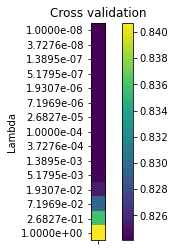

Accuracy of ridge_regression on the local test set : 0.7440
F1-score of ridge_regression on the local test set : 0.5704


In [4]:
acc_local_test, f1_local_test, w_best, _, best_lambda = run_experiment(y, x, 'ridge_regression', 1, 0.8, [], degree_exp=False, expansion=False, standard=False)

In [5]:
best_lambda

1e-08

## Exploratory Data Analysis

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

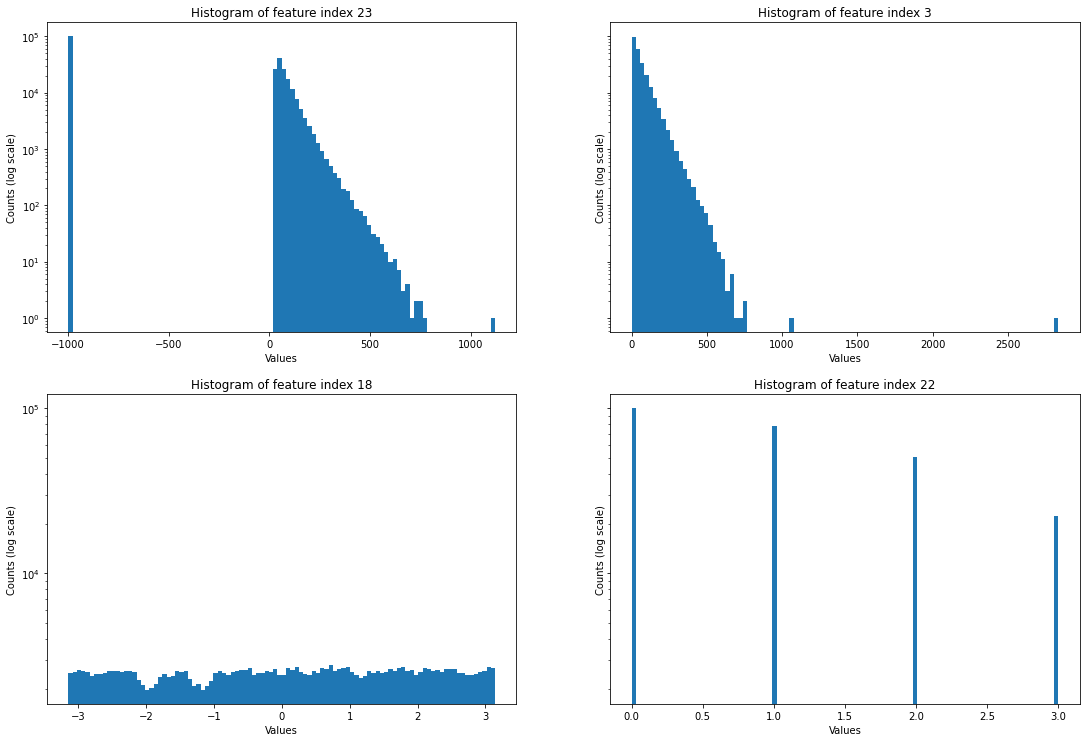

In [6]:
quad_histograms(x,23,3,18,22)

We can see that some features clearly have default values to -999, some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values.

### Data cleaning

In [7]:
# Check if the values for the number of jets are non negative integers
# Column 22 corresponds to this variable
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


In [8]:
# Check that no value in the table is a nan value
np.sum(x==np.nan)

0

We can see that we have 250'000 data points with 30 features each.

In [9]:
x.shape

(250000, 30)

In [10]:
np.sum(x == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the mean of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [11]:
# We remove the features where more than half of the rows are -999
x_cleaned, col_removed_training = remove_col_default_values(x)

In [12]:
col_removed_training

[4, 5, 6, 12, 26, 27, 28]

We can see that with this method we dropped 7 columns.

We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [13]:
check_nb_rows_default_features(x_cleaned)

Number of rows : 0




For the remaining default values, we decided to set them to -999. We did this instead of e.g. replacing them by the mean or median of the remaining values because we noted that the models actually performed better.

In [15]:
x_cleaned, default_values_training = replace_by_default_value(x_cleaned)

Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [17]:
cols_angle = [11, 14, 16, 21]
x_cleaned = check_all_azimuth_angles(x_cleaned, cols_angle)

Number of values outside [-pi;pi[ (col 11): 0
Number of values outside [-pi;pi[ (col 14): 0
Number of values outside [-pi;pi[ (col 16): 0
Number of values outside [-pi;pi[ (col 21): 0


We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

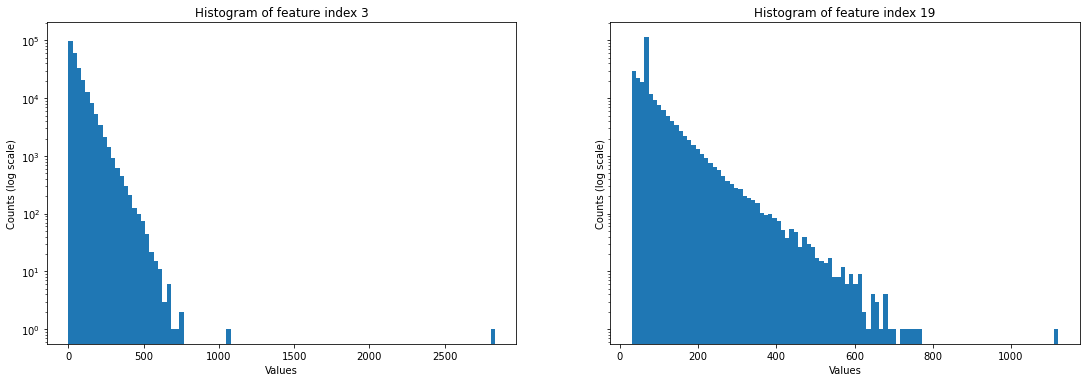

In [18]:
double_histograms(x_cleaned, 3,19)

#### Removing outliers
We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).


We will deal with them using a method based on the Inter Quartile Range (IQR). 

In [19]:
x_cleaned, above_lim_training, below_lim_training = clip_IQR(x_cleaned)

We have now a cleaned version of the dataset. Let's take a look at the performance of the ridge regression with our cleaning. We also standardise our dataset. 

End of standardisation
Beginning training
Beginning cross-validation


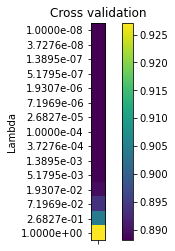

Accuracy of ridge_regression on the local test set : 0.7091
F1-score of ridge_regression on the local test set : 0.6564


In [20]:
acc_local_test, f1_local_test, w_best, _, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, [], degree_exp=False, expansion=False, standard=True)

In [21]:
best_lambda

0.0001

Surprisingly, we can see that the overall performance over the ridge regression decreases with our cleaning. Nevertheless, let's now apply the feature expansion (without the power expansion for the moment) to our dataset and see what are the results 

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


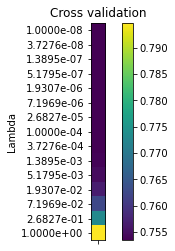

Accuracy of ridge_regression on the local test set : 0.8081
F1-score of ridge_regression on the local test set : 0.7058


In [22]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, cols_angle, degree_exp=False, expansion=True, standard=True)

In [23]:
best_lambda

7.196856730011514e-06

We can see, that we considerably increase the performance of the ridge_regression by adding the feature expansion (without power expansion for the moment). 

But now, we can ask ourselves if the pre-processing and data cleaning was really useful. To answer that question, we can try to do the feature expansion on the raw data set (note that we need to adapt the angle columns as no columns are removed)

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


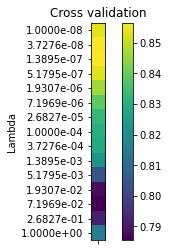

Accuracy of ridge_regression on the local test set : 0.7833
F1-score of ridge_regression on the local test set : 0.6569


In [24]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x, 'ridge_regression', 1, 0.8, [14, 17, 19, 24, 28], degree_exp=False, expansion=True, standard=True)

In [25]:
best_lambda

0.07196856730011514

From the previous result, we can see that our feature expansion combined with the data cleaning is more performant than the feature expansion on the raw dataset. 

Finally, the last things that we will add to our model is the power expansion on the cleaned dataset. The best degree is again determined by cross-validation. 

End of standardisation
End of processing + expansion
Beginning training
Beginning cross-validation


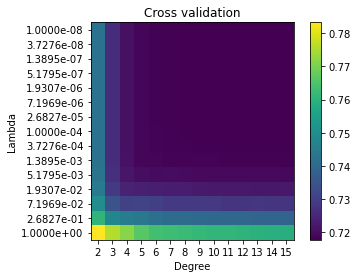

Accuracy of ridge_regression on the local test set : 0.8263
F1-score of ridge_regression on the local test set : 0.7368


In [26]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned, 'ridge_regression', 1, 0.8, cols_angle, max_degree=15, degree_exp=True, expansion=True, standard=True)

In [27]:
best_degree, best_lambda

(10, 7.196856730011514e-06)

We can see that the degree for which the loss is minimised is degree $deg=10$ with which we reach $82.63\%$ of accuracy.

With these two parameters, we reach our highest score in aicrowd.com with $82.8\%$ accuracy and a F1-score of $0.738$.

In [28]:
from run import *
main()

==> Loading and preprocessing training data...

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 3

==> Training model...

==> Loading and preprocessing test data...

Number of values outside [-pi;pi[ (col 11): 19
Number of values outside [-pi;pi[ (col 14): 17
Number of values outside [-pi;pi[ (col 16): 22
Number of values outside [-pi;pi[ (col 21): 9
(704,)

==> Predicting labels for the test set...

==> Creating submission file...

==> Submission files saved.
